In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from pprint import pprint
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: 0 if value<=5 else 1 if value< 7 else 2)
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=[0,1,2])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=[0,1,2])
#Feature "Crisp" denotes the acidity of a wine over its sweetness/dryness
white_wine["crisp"]=white_wine["volatile_acidity"]/white_wine["residual_sugar"]
red_wine["crisp"]=red_wine["volatile_acidity"]/red_wine["residual_sugar"]
#Combining the two wine databases
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [2]:
x=wines.drop(["quality","quality_label"],axis=1)
y=wines["quality_label"]
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
xtrain_norm=xtrain
xtest_norm=xtest

In [3]:
#Data is normalised since distribution for all except pH is skewed
#Normalisation only has a noticeable impact in non RF methods, and it's better with StandardScaler
#However it results in lost of variance, concentrating most wines in one quality
#If not normalised, the accuracy is less than 50%. With normalisation it it around 57%.
if False:    
    norm=StandardScaler()
    norm_fit=norm.fit(xtrain)
    xtrain_norm=norm_fit.transform(xtrain)
    xtest_norm=norm_fit.transform(xtest)

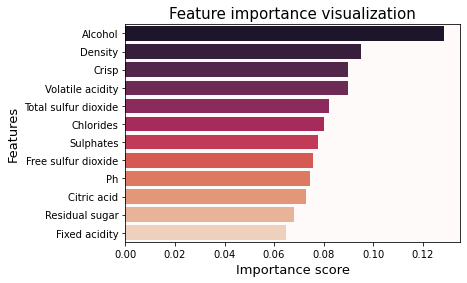

In [4]:
#Feature visualization for RF
temp=RandomForestClassifier(n_estimators=100)
temp.fit(xtrain,ytrain)
feature_imp=pd.Series(temp.feature_importances_,index=x.columns[:12]).sort_values(ascending=False)
feature_imp.index=feature_imp.index.str.replace("_"," ")
feature_imp.index=feature_imp.index.str.capitalize()
sns.barplot(x=feature_imp,y=feature_imp.index,palette="rocket",color="snow").set_facecolor(color="snow")
plt.xlabel("Importance score",fontsize=13)
plt.ylabel("Features",fontsize=13)
plt.title("Feature importance visualization",fontsize=15)
plt.show()

In [5]:
# RandomizedSearch parameter tuning
# n_estimators=[200,400,600,800,1000]
# max_features=["auto","sqrt","log2",0.3]
# max_depth=[int(x) for x in np.linspace(10,100,num=10)]
# max_depth.append(None)
# min_samples_split=[1,2,3,4,5]
# min_samples_leaf=[1,2,3,4]
# bootstrap=[True,False]
# grid={"n_estimators":n_estimators,"max_features":max_features,"max_depth":max_depth,
# "min_samples_split":min_samples_split,"min_samples_leaf":min_samples_leaf,"bootstrap":bootstrap}
# rf=RandomForestRegressor()
# random_grid=RandomizedSearchCV(estimator=rf,param_distributions=grid,n_iter=100,cv=3,verbose=2,random_state=42,n_jobs=-1)
# random_grid.fit(xtrain,ytrain)
# print(random_grid.best_params_)

In [6]:
# #GridSearch parameter tuning
# n_estimators=[500,600,700]
# max_features=["auto","log2",0.3]
# max_depth=[50,60,70]
# min_samples_split=[1,2,3]
# min_samples_leaf=[2,3,4]
# bootstrap=[False,True]
# best_grid={"bootstrap":bootstrap,"max_depth":max_depth,"max_features":max_features,"min_samples_leaf":min_samples_leaf,
# "min_samples_split":min_samples_split,"n_estimators":n_estimators}
# rf=RandomForestRegressor()
# grid_search=GridSearchCV(estimator=rf,param_grid=best_grid,cv=3,n_jobs=-1,verbose=2)
# grid_search.fit(xtrain_norm,ytrain)
# print(grid_search.best_params_)

In [7]:
#Hyperparamater for quality label depending on dataset:
    #RED WINES
strap=False
depth=60
features="log2"
samples_leaf=1
samples_split=3
estimators=900
oob=False
    #WHITE WINES
strap=False
depth=50
features="log2"
samples_leaf=1
samples_split=2
estimators=700
oob=False
    #COMBINED
strap=False
depth=50
features="log2"
samples_leaf=2
samples_split=3
estimators=700
oob=False
#Hyperparamater for quality depending on dataset:
    #RED WINES
strap=False
depth=100
features="sqrt"
samples_leaf=2
samples_split=2
estimators=1000
oob=False
    #WHITE WINES
strap=False
depth=50
features="log2"
samples_leaf=2
samples_split=3
estimators=700
oob=False
    #COMBINED
strap=False
depth=60
features=0.3
samples_leaf=2
samples_split=2
estimators=600
oob=False

In [8]:
#Quality_Label_Red=70%
#Quality_Label_White=74%
#Quality_Label_Combined=71%
#Quality_Red=69%
#Quality_White=70%
#Quality_Combined=69%

In [9]:
strap=False
depth=50
features="log2"
samples_leaf=2
samples_split=3
estimators=700
oob=False

0.7446153846153846
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       477
           1       0.71      0.76      0.73       567
           2       0.76      0.65      0.70       256

    accuracy                           0.74      1300
   macro avg       0.75      0.73      0.74      1300
weighted avg       0.75      0.74      0.74      1300



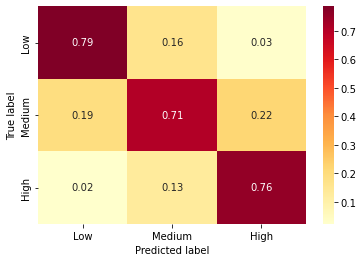

In [10]:
rf=RandomForestClassifier(n_estimators=estimators,max_depth=depth,max_features=features,
min_samples_leaf=samples_leaf,min_samples_split=samples_split,bootstrap=strap,oob_score=oob,n_jobs=-1)
rf.fit(xtrain_norm,ytrain)
pred_rf=rf.predict(xtest_norm)
a_rf=accuracy_score(ytest,pred_rf)
print(a_rf)
print(classification_report(ytest,pred_rf))
ax=plt.subplot()
cm=confusion_matrix(ytest,pred_rf,normalize="pred")
sns.heatmap(cm,ax=ax,fmt=".2f",annot=True,cmap="YlOrRd",xticklabels=(["Low","Medium","High"]),yticklabels=(["Low","Medium","High"]))
ax.set_xlabel("Predicted label");ax.set_ylabel("True label")
ax.set_label("Prediction accuracy")
plt.show()

In [11]:
#Logistic Regreession ~55%
lr=LogisticRegression()
lr.fit(xtrain_norm,ytrain)
pred_lr=lr.predict(xtest_norm)
a_lr=accuracy_score(ytest,pred_lr)
print(a_lr)
print(classification_report(ytest,pred_lr))
plot_confusion_matrix(lr,xtest,ytest)
plt.show()

c:\Users\giorg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       477
           1       0.47      0.64      0.55       567
           2       0.42      0.21      0.28       256

    accuracy                           0.50      1300
   macro avg       0.49      0.45      0.45      1300
weighted avg       0.50      0.50      0.49      1300



NameError: name 'plot_confusion_matrix' is not defined

0.5738461538461539
              precision    recall  f1-score   support

           0       0.62      0.65      0.64       477
           1       0.54      0.67      0.59       567
           2       0.59      0.23      0.33       256

    accuracy                           0.57      1300
   macro avg       0.58      0.51      0.52      1300
weighted avg       0.58      0.57      0.56      1300



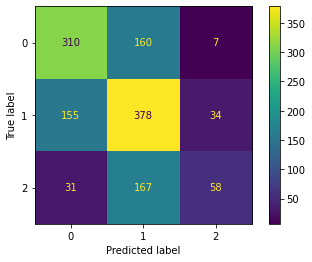

In [ ]:
#SVC ~57%
svc=SVC(C=1000)
svc.fit(xtrain_norm,ytrain)
pred_svc=svc.predict(xtest_norm)
a_svc=accuracy_score(ytest,pred_svc)
print(a_svc)
print(classification_report(ytest,pred_svc))
plot_confusion_matrix(svc,xtest,ytest)
plt.show()

0.4869230769230769
              precision    recall  f1-score   support

           0       0.51      0.54      0.53       477
           1       0.48      0.62      0.54       567
           2       0.37      0.10      0.16       256

    accuracy                           0.49      1300
   macro avg       0.45      0.42      0.41      1300
weighted avg       0.47      0.49      0.46      1300



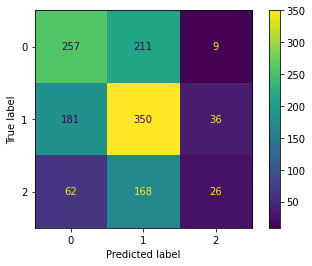

In [ ]:
#KNN ~58%
knn=KNeighborsClassifier(n_neighbors=50,leaf_size=20)
knn.fit(xtrain_norm,ytrain)
pred_knn=knn.predict(xtest_norm)
a_knn=accuracy_score(ytest,pred_knn)
print(a_knn)
print(classification_report(ytest,pred_knn))
plot_confusion_matrix(knn,xtest,ytest)
plt.show()

Text(0.5, 1.0, 'Comperative accuracy of different models')

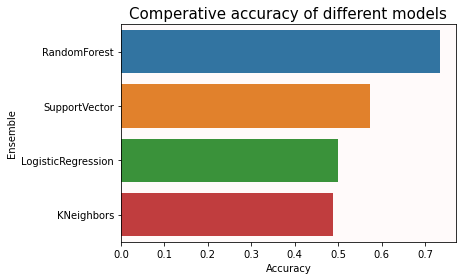

In [ ]:
%matplotlib inline
mods=pd.DataFrame({"Ensemble":["RandomForest","LogisticRegression","SupportVector","KNeighbors"],"Accuracy":[a_rf,a_lr,a_svc,a_knn]})
mods.sort_values(by="Accuracy",ascending=False,inplace=True)
sns.barplot(x="Accuracy",y="Ensemble",data=mods).set_facecolor(color="snow")
plt.title("Comperative accuracy of different models",fontsize=15)